<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۰) وارد کردن کتابخانه‌های مورد نیاز (XGBoost)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در این نوتبوک هدف ما آموزش و تنظیم (Tuning) مدل <b>XGBoost</b> است.  
XGBoost یک الگوریتم قدرتمند مبتنی بر درخت‌های تصمیم و روش <b>Boosting</b> است که معمولاً در مسائل جدولی (Tabular Data) عملکرد بسیار خوبی دارد.
<br><br>
برخلاف مدل‌هایی مثل KNN، XGBoost معمولاً به Scaling حساس نیست؛ چون تصمیم‌گیری آن بر اساس تقسیم‌بندی درختی انجام می‌شود نه فاصله.
<br><br>
در ادامه، علاوه بر آموزش مدل، چندین پارامتر مهم را تست می‌کنیم تا بهترین تنظیمات ممکن بر اساس معیار <code>F1-Score</code> به دست آید.
</font>
</p>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer

from xgboost import XGBClassifier


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۱) خواندن داده‌های پیش‌پردازش‌شده
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در نوتبوک پیش‌پردازش، داده‌ها پاکسازی و تبدیل به فرم عددی شده‌اند.  
در این نوتبوک تمرکز فقط روی مدل‌سازی است؛ بنابراین داده‌های آماده را از فایل می‌خوانیم تا پروژه ما:
<br>
- مرتب و ماژولار باشد،
<br>
- و بتوانیم برای هر مدل یک نوتبوک مستقل داشته باشیم.
</font>
</p>


In [3]:
train_data = pd.read_csv("../../data/train_processed.csv")
print("train:", train_data.shape)
train_data.head()


train: (100380, 18)


,ReserveStatus,Male,Price,From,To,Domestic,VehicleClass,TripReason,Cancel,TicketPerOrder,family,Departure_Created,DepartureMonth,Bus,InternationalPlane,Plane,Train,Discount
0,5,True,6565575.0,217.0,80.0,1,0.0,1,0,3,False,10,11,False,False,True,False,True
1,5,True,9500000.0,171.0,80.0,1,0.0,0,0,2,True,2,8,False,False,True,False,False
2,3,False,2000000.0,135.0,37.0,1,1.0,1,0,3,False,0,9,True,False,False,False,False
3,2,False,40000.0,64.0,85.0,1,1.0,0,0,6,True,0,6,False,False,False,True,False
4,3,True,1130000.0,68.0,244.0,1,1.0,0,0,1,False,1,6,True,False,False,False,False


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۲) جدا کردن ویژگی‌ها (X) و متغیر هدف (y)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای مدل‌سازی باید ستون هدف <code>TripReason</code> را به عنوان y جدا کنیم و باقی ستون‌ها را به عنوان ویژگی‌های ورودی X در نظر بگیریم.  
این کار از ورود ناخواسته ستون هدف به ورودی مدل جلوگیری کرده و روند آموزش را شفاف می‌کند.
</font>
</p>


In [4]:
X = train_data.drop(columns=["TripReason"])
y = train_data["TripReason"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)


(80304, 17) (20076, 17)


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۳) تقسیم داده به Train و Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای ارزیابی واقعی مدل، بخشی از داده را به عنوان Validation کنار می‌گذاریم.  
با استفاده از <code>stratify</code> نسبت کلاس‌ها در هر دو بخش مشابه می‌ماند تا ارزیابی منصفانه‌تر و پایدارتر شود.
</font>
</p>


In [5]:
n_classes = y.nunique()

if n_classes == 2:
    objective = "binary:logistic"
    eval_metric = "logloss"
else:
    objective = "multi:softprob"
    eval_metric = "mlogloss"


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۴) معیار ارزیابی: Macro F1-Score
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
چون معیار داوری مسئله <code>F1-Score</code> است، ما نیز مدل را با همین معیار ارزیابی می‌کنیم.  
از <b>Macro-F1</b> استفاده می‌کنیم تا هر کلاس وزن برابر داشته باشد و مدل فقط روی کلاس غالب خوب عمل نکند.
</font>
</p>


In [6]:
baseline_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective=objective,
    eval_metric=eval_metric,
    n_jobs=-1
)

if n_classes > 2:
    baseline_xgb.set_params(num_class=n_classes)

baseline_xgb.fit(X_train, y_train)
pred_base = baseline_xgb.predict(X_val)

print("Baseline Validation Macro-F1:", f1_score(y_val, pred_base, average="macro"))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, pred_base))
print("\nClassification Report:\n", classification_report(y_val, pred_base))


Baseline Validation Macro-F1: 0.8233517698329802

Confusion Matrix:
 [[ 6549  2272]
 [ 1164 10091]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79      8821
           1       0.82      0.90      0.85     11255

    accuracy                           0.83     20076
   macro avg       0.83      0.82      0.82     20076
weighted avg       0.83      0.83      0.83     20076



<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۵) آموزش مدل پایه (Baseline) با XGBoost
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در ابتدا یک مدل پایه با تنظیمات معقول آموزش می‌دهیم تا یک نقطه شروع داشته باشیم.  
سپس در مراحل بعد با تنظیم پارامترها (Tuning) تلاش می‌کنیم عملکرد را بهبود دهیم.
</font>
</p>


In [7]:
f1_macro = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "n_estimators": [200, 300, 400, 600, 800],
    "max_depth": [3, 5, 7, 9, 12],
    "learning_rate": [0.03, 0.05, 0.08, 0.1, 0.15],
    "subsample": [0.6, 0.75, 0.85, 1.0],
    "colsample_bytree": [0.6, 0.75, 0.85, 1.0],
    "min_child_weight": [1, 3, 5, 7, 10],
    "gamma": [0, 0.2, 0.5, 1, 2],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 1.5, 2, 3]
}

xgb = XGBClassifier(
    random_state=42,
    objective=objective,
    eval_metric=eval_metric,
    n_jobs=-1
)

if n_classes > 2:
    xgb.set_params(num_class=n_classes)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,              # تعداد تست‌ها (می‌تونی 40 هم بزاری ولی کندتر میشه)
    scoring=f1_macro,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best CV Macro-F1:", search.best_score_)
print("Best Params:\n", search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best CV Macro-F1: 0.8369972860818518
Best Params:
 {'subsample': 0.85, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۶) تنظیم پارامترهای XGBoost (Tuning) با Cross-Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
XGBoost پارامترهای زیادی دارد و انتخاب دستی بهترین ترکیب همیشه ساده نیست.  
برای اینکه تست ما واقعی و قابل دفاع باشد، از <b>Cross-Validation</b> به همراه <b>RandomizedSearch</b> استفاده می‌کنیم تا چندین ترکیب از پارامترها بررسی شود.
<br><br>
برخی پارامترهای مهم:
<br>
- <code>n_estimators</code>: تعداد درخت‌ها
<br>
- <code>max_depth</code>: عمق هر درخت (کنترل پیچیدگی)
<br>
- <code>learning_rate</code>: نرخ یادگیری (Trade-off با n_estimators)
<br>
- <code>subsample</code> و <code>colsample_bytree</code>: جلوگیری از overfitting
<br>
- <code>min_child_weight</code> و <code>gamma</code>: کنترل سخت‌گیری برای split ها
</font>
</p>


In [8]:
best_xgb = search.best_estimator_
best_xgb.fit(X_train, y_train)

pred = best_xgb.predict(X_val)
print("Final Validation Macro-F1:", f1_score(y_val, pred, average="macro"))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, pred))
print("\nClassification Report:\n", classification_report(y_val, pred))


Final Validation Macro-F1: 0.8365163900926451

Confusion Matrix:
 [[ 6694  2127]
 [ 1055 10200]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.81      8821
           1       0.83      0.91      0.87     11255

    accuracy                           0.84     20076
   macro avg       0.85      0.83      0.84     20076
weighted avg       0.84      0.84      0.84     20076



<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۷) ارزیابی مدل نهایی و تحلیل نتایج
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
پس از یافتن بهترین پارامترها، مدل نهایی را با همان تنظیمات روی داده Train آموزش می‌دهیم و روی Validation ارزیابی می‌کنیم.  
علاوه بر F1-Score، ماتریس درهم‌ریختگی و گزارش طبقه‌بندی نمایش داده می‌شود تا نوع خطاهای مدل مشخص شود.
</font>
</p>


In [9]:
importances = best_xgb.feature_importances_
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(20)


,feature,importance
8,TicketPerOrder,0.309011
9,family,0.255024
5,Domestic,0.045729
12,Bus,0.044282
13,InternationalPlane,0.042906
4,To,0.039208
14,Plane,0.031833
15,Train,0.030152
3,From,0.027755
1,Male,0.027475


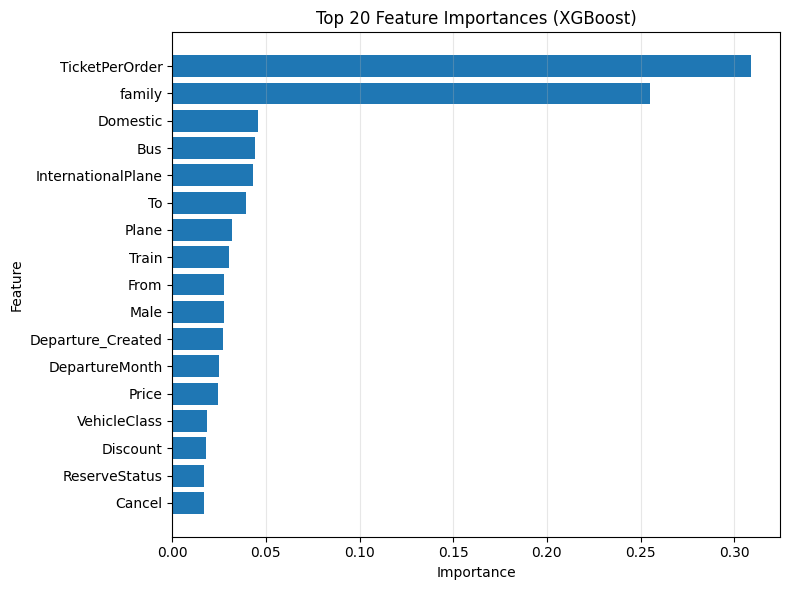

In [10]:
topk = 20
tmp = feat_imp.head(topk).iloc[::-1]  # برعکس برای زیبایی

plt.figure(figsize=(8, 6))
plt.barh(tmp["feature"], tmp["importance"])
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۸) تحلیل اهمیت ویژگی‌ها (Feature Importance)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
یکی از مزیت‌های مدل‌های مبتنی بر درخت امکان بررسی اهمیت ویژگی‌هاست.  
در این بخش اهمیت ویژگی‌ها را استخراج می‌کنیم تا بفهمیم کدام ویژگی‌ها بیشترین نقش را در پیش‌بینی TripReason داشته‌اند.
</font>
</p>
